In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import pydicom
import json

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler,LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

# from imblearn.over_sampling import RandomOverSampler
import torch
from torch.utils.data import DataLoader,TensorDataset
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns

from helpers import get_ddsm_table, get_INBreast_table, get_VinDR_table, mask_image, run_intensity_functions, run_glcm_features, get_master_df, process_image
stage = 'process'
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")

In [2]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
def run_tsne(features, labels):
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    label_encoder = LabelEncoder()
    numeric_labels = label_encoder.fit_transform(labels)
    tsne_results = tsne.fit_transform(features_scaled)
    tsne_df = pd.DataFrame(tsne_results, columns=["TSNE1", "TSNE2"])
    tsne_df['Label'] = label_encoder.inverse_transform(numeric_labels)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=tsne_df, x="TSNE1", y="TSNE2", hue="Label", palette='Set1', s=100, alpha=0.7)
    plt.title("t-SNE of Image Features with Labels")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend(title="Classes")
    plt.show()

    return tsne_df

In [3]:
def get_datasets(df):
    # Set Data Columns and Output Column
    scaler = StandardScaler()
    X = scaler.fit_transform(df.drop(columns=['file_name', 'vendor', 'laterality', 'view_position', 'breast_density']))
    le = LabelEncoder()
    y = le.fit_transform(df['vendor'])

    # Set Train and Test data
    X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state=42)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    input_size = X_train.shape[1]
    num_classes = len(np.unique(y))

    return input_size, num_classes, train_loader, test_loader, le

def build_model(input_size, num_classes):
    model = nn.Sequential(
    nn.Linear(input_size, 64), 
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 32),         
    nn.ReLU(),
    nn.Linear(32, num_classes) 
    )
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    return model, criterion, optimizer

def train_model(model, optimizer, criterion, train_loader):
    train_metrics = {"loss": [], "accuracy": [], "f1": []}
    patience = 5
    min_delta = 0.001
    best_loss = float('inf')
    epochs_no_improve = 0
    early_stop = False

    for epoch in tqdm(range(200)):
        if early_stop:
            print(f"Early stopping at epoch {epoch + 1}")
            break

        # Training phase
        model.train()
        running_loss = 0.0
        y_true_train, y_pred_train = [], []

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            y_true_train.extend(labels.cpu().numpy())
            y_pred_train.extend(preds.cpu().numpy())

        # Calculate training metrics
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = accuracy_score(y_true_train, y_pred_train)
        epoch_f1 = f1_score(y_true_train, y_pred_train, average='weighted')


        train_metrics["loss"].append(epoch_loss)
        train_metrics["accuracy"].append(epoch_accuracy)
        train_metrics["f1"].append(epoch_f1)

        # Early stopping check
        if best_loss - epoch_loss > min_delta:
            best_loss = epoch_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                early_stop = True
    
    return train_metrics

def test_model(model, test_loader):
    test_metrics = {"accuracy": [], "f1": []}
    model.eval()
    y_true_test, y_pred_test = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)
            y_true_test.extend(labels.cpu().numpy())
            y_pred_test.extend(preds.cpu().numpy())

    # Calculate metrics for test set
    test_accuracy = accuracy_score(y_true_test, y_pred_test)
    test_f1 = f1_score(y_true_test, y_pred_test, average='weighted')

    test_metrics["accuracy"].append(test_accuracy)
    test_metrics["f1"].append(test_f1)

    return test_metrics

def plot_metrcis(train_metrics):
    epochs = range(1, len(train_metrics["loss"]) + 1)
    
    plt.figure(figsize=(6,6))
    plt.plot(epochs, train_metrics["loss"], label="Loss")
    plt.plot(epochs, train_metrics["accuracy"], label="Accuracy")
    plt.plot(epochs, train_metrics["f1"], label="F1 Score")
    plt.title("Training Metrics")
    plt.xlabel("Epochs")
    plt.ylabel("Metric Value")
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_cm(model, test_loader, le):
    model.eval()
    y_true_test, y_pred_test = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true_test.extend(labels.cpu().numpy())
            y_pred_test.extend(preds.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(y_true_test, y_pred_test)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    print(classification_report(y_true_test, y_pred_test, target_names=le.classes_))

<h3>Load and Process Data</h3>

In [5]:
if(stage == 'Load Data'):
    ddsm_df = get_ddsm_table("../DDSM")
    INbreast_df = get_INBreast_table("../INbreast Release 1.0")
    vindr_df = get_VinDR_table("../VinDr")
    master_df = get_master_df(vindr_df, ddsm_df, INbreast_df)

    df_data = []
    for i in tqdm(range(len(master_df))):
        row = master_df.iloc[i]
        image_stats = {
            "file_name": row['full_path'],
            "vendor": row['Manufacturer'],
            "laterality": row['laterality'], 
            "view_position": row['view_position'],
            "breast_density": row['breast_density']    
        }
        pixel_array = pydicom.dcmread(row['full_path']).pixel_array
        breast_tissue_image = mask_image(pixel_array)
        intensity_stats, hist_features = run_intensity_functions(breast_tissue_image)
        image_stats.update(intensity_stats)
        image_stats.update(hist_features)
        glcm_stats = run_glcm_features(breast_tissue_image)
        image_stats.update(glcm_stats)
        df_data.append(image_stats)

    image_stats_df = pd.DataFrame(df_data)
    image_stats_df.to_csv('complete_stats_normalized.csv', index=False)


100%|██████████| 2885/2885 [31:29<00:00,  1.53it/s]


<h3>Run TSNE analysis</h3>

In [8]:
if(stage == 'TSNE'):
    image_stats_df = pd.read_csv('complete_stats_normalized.csv')


<h4>TSNE with all 60 Features</h4>

c:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


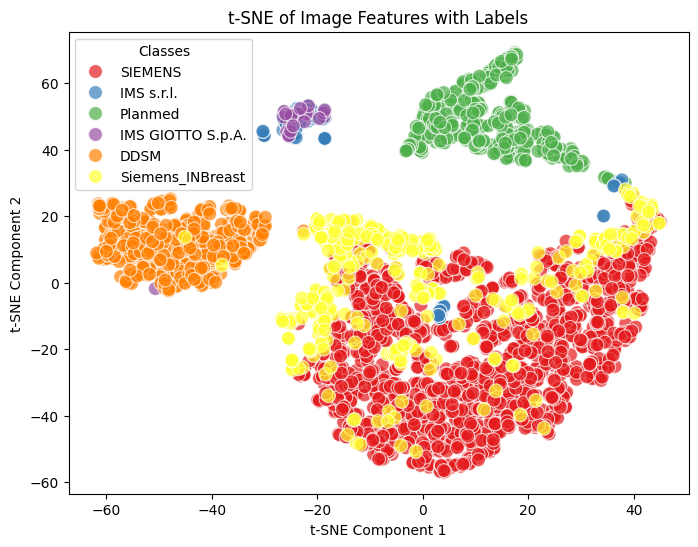

In [9]:
if(stage == 'TSNE'):
    feature_set = image_stats_df.iloc[:,5:]
    features = np.array(feature_set)
    labels = image_stats_df['vendor'].values
    results = run_tsne(features, labels)

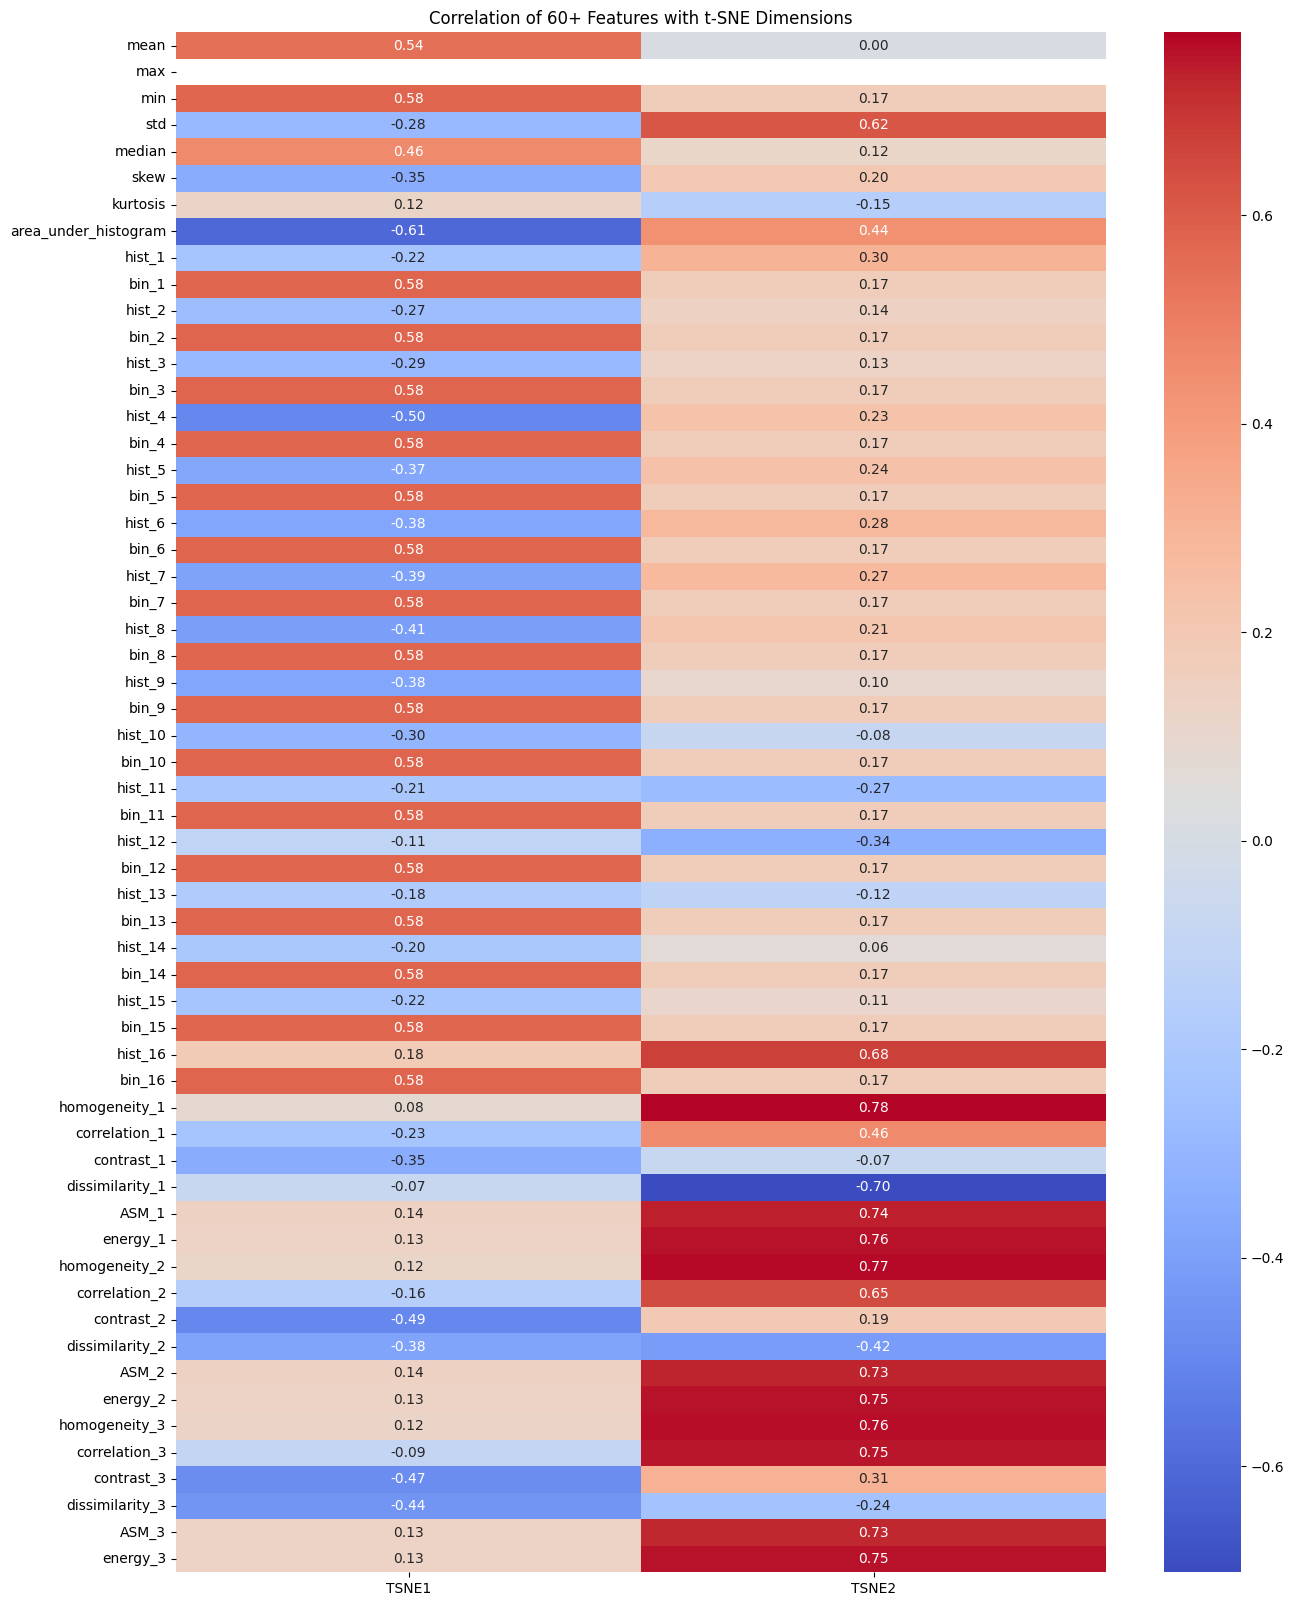

In [10]:
if(stage == 'TSNE'):
    correlations = pd.concat([feature_set, results.iloc[:,:2]], axis=1).corr()
    tsne_corr = correlations.loc[feature_set.columns, results.iloc[:,:2].columns]
    plt.figure(figsize=(15, 20))
    sns.heatmap(tsne_corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation of 60+ Features with t-SNE Dimensions")
    plt.show()

<h4>TSNE with only minimum features</h4>

c:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


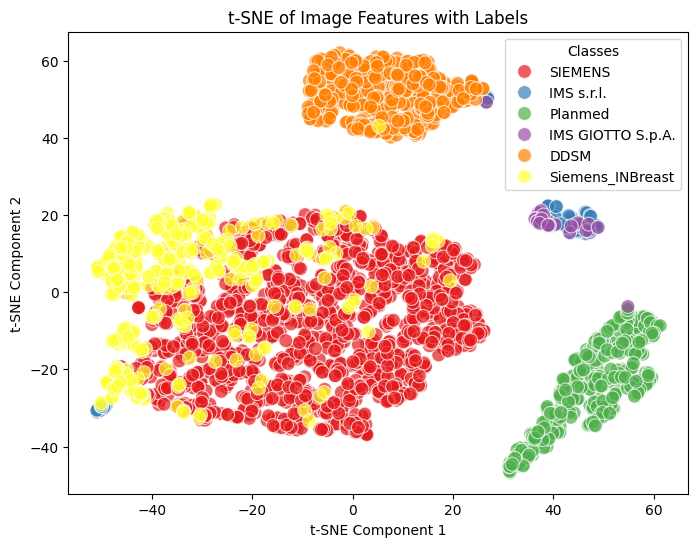

In [15]:
if(stage == 'TSNE'):
    min_features = ['mean', 'std', 'kurtosis', 'area_under_histogram', 'homogeneity_1', 'correlation_2', 'contrast_2', 'dissimilarity_3', 'ASM_2']
    feature_set = image_stats_df[min_features]
    features = np.array(feature_set)
    labels = image_stats_df['vendor'].values
    results = run_tsne(features, labels)

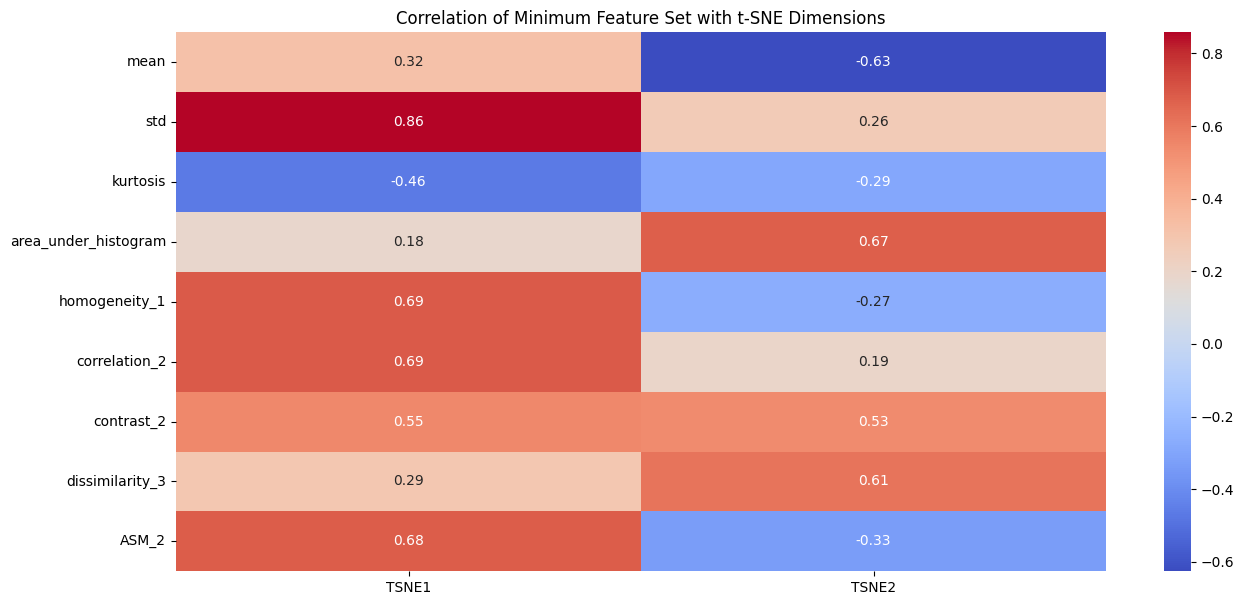

In [16]:
if(stage == 'TSNE'):
    correlations = pd.concat([feature_set, results.iloc[:,:2]], axis=1).corr()
    tsne_corr = correlations.loc[feature_set.columns, results.iloc[:,:2].columns]
    plt.figure(figsize=(15, 7))
    sns.heatmap(tsne_corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation of Minimum Feature Set with t-SNE Dimensions")
    plt.show()

<h3>NN Classifier for Class Prediction</h3>

In [165]:
if(stage=='NN'):
    image_stats_df = pd.read_csv('complete_stats_normalized.csv')
    image_stats_df['vendor'] = image_stats_df['vendor'].replace(['IMS s.r.l.', 'IMS GIOTTO S.p.A.'], 'IMS')
    df = image_stats_df.groupby('vendor').sample(n=70)
    
    input_size, num_classes, train_loader, test_loader, le = get_datasets(df)
    model, criterion, optimizer = build_model(input_size, num_classes)
    train_metrics = train_model(model, optimizer, criterion, train_loader)

    plot_metrcis(train_metrics)

 14%|█▍        | 29/200 [00:00<00:04, 39.04it/s]

Early stopping at epoch 30


In [173]:
if(stage == 'NN'):
    acc = []
    f1 = []
    for i in range(100):
        df = image_stats_df.groupby('vendor').sample(n=70)
        _,_,_, test_loader, le = get_datasets(df)
        test_metrics = test_model(model, test_loader)
        acc.append(test_metrics['accuracy'][0])
        f1.append(test_metrics['f1'][0])
        
    test_accuracy = np.mean(acc)
    test_f1 = np.mean(f1)
    
    print(f"Test Metrics - Accuracy: {test_accuracy:.4f}, F1: {test_f1:.4f}") 

Test Metrics - Accuracy: 0.9583, F1: 0.9585


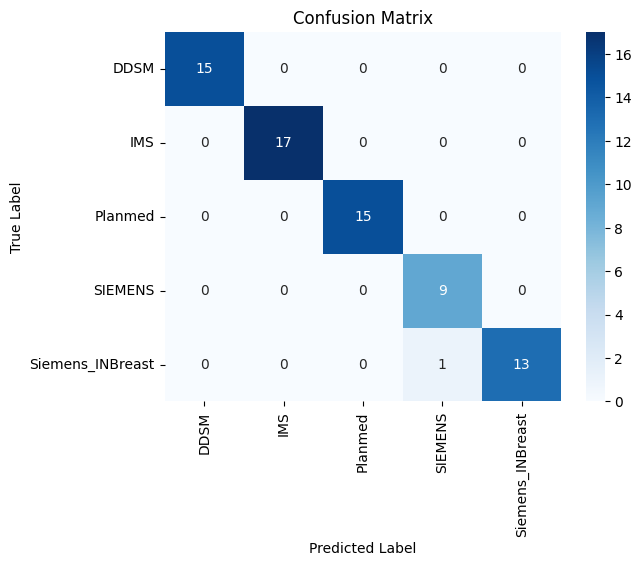

                  precision    recall  f1-score   support

            DDSM       1.00      1.00      1.00        15
             IMS       1.00      1.00      1.00        17
         Planmed       1.00      1.00      1.00        15
         SIEMENS       0.90      1.00      0.95         9
Siemens_INBreast       1.00      0.93      0.96        14

        accuracy                           0.99        70
       macro avg       0.98      0.99      0.98        70
    weighted avg       0.99      0.99      0.99        70



In [183]:
if(stage == 'NN'):
    plot_cm(model, test_loader, le)

In [184]:
if(stage == 'NN'):
    with open('Classification Results/normalized_no_processing_windows.json', 'w') as json_file:
        json.dump({'accuracy': test_accuracy, 'f1': test_f1}, json_file, indent=4)
    torch.save(model, 'model.pth')

<h3>Process Images</h3>

functions to apply:
clahe: https://scikit-image.org/docs/0.24.x/api/skimage.exposure.html#skimage.exposure.equalize_adapthist => Planmed
unsharpen: https://scikit-image.org/docs/stable/auto_examples/filters/plot_unsharp_mask.html => Planmed, IMS
wavelet denoising: https://scikit-image.org/docs/stable/auto_examples/filters/plot_denoise_wavelet.html => Siemens, Siemens INBreast

In [4]:
if(stage == 'process'):
    image_stats_df = pd.read_csv('complete_stats_normalized.csv')
    image_stats_df = image_stats_df.iloc[:, 0:5]

In [5]:
if(stage=='process'):
    df_data = []
    for i in tqdm(range(len(image_stats_df))):
        image_stats = {}
        row = image_stats_df.iloc[i]
        pixel_array = pydicom.dcmread(row['file_name']).pixel_array
        breast_tissue_image = mask_image(pixel_array)
        vendor = row['vendor']
        img = process_image(breast_tissue_image, vendor) # -> Process the image
        intensity_stats, hist_features = run_intensity_functions(img)
        image_stats.update(intensity_stats)
        image_stats.update(hist_features)
        glcm_stats = run_glcm_features(img)
        image_stats.update(glcm_stats)
        df_data.append(image_stats)
    df_data = pd.DataFrame(df_data)
    image_stats_df = pd.concat([image_stats_df, df_data], axis=1)
    image_stats_df.to_csv('complete_stats_processed.csv', index=False)

100%|██████████| 2885/2885 [32:22<00:00,  1.48it/s]


In [64]:
image_stats_df = pd.read_csv('complete_stats_processed.csv')

In [7]:
min_features = ['mean', 'std', 'kurtosis', 'area_under_histogram', 'homogeneity_1', 'correlation_2', 'contrast_2', 'dissimilarity_3', 'ASM_2']

In [11]:
temp = image_stats_df
temp[temp.notnull().all(axis=1)].head()

,file_name,vendor,laterality,view_position,breast_density,mean,max,min,std,median,skew,kurtosis,area_under_histogram,hist_1,bin_1,hist_2,bin_2,hist_3,bin_3,hist_4,bin_4,hist_5,bin_5,hist_6,bin_6,hist_7,bin_7,hist_8,bin_8,hist_9,bin_9,hist_10,bin_10,hist_11,bin_11,hist_12,bin_12,hist_13,bin_13,hist_14,bin_14,hist_15,bin_15,hist_16,bin_16,homogeneity_1,correlation_1,contrast_1,dissimilarity_1,ASM_1,energy_1,homogeneity_2,correlation_2,contrast_2,dissimilarity_2,ASM_2,energy_2,homogeneity_3,correlation_3,contrast_3,dissimilarity_3,ASM_3,energy_3
0,../VinDr\8269f5971eaca3e5d3772d1796e6bd7a\dd9c...,SIEMENS,L,CC,DENSITY C,0.408004,1.0,0.250000,0.146956,0.500000,0.338395,-0.538413,1457086.5,783437,0.250000,0,0.296875,0,0.34375,0,0.390625,0,0.437500,965078,0.484375,0,0.531250,0,0.578125,0,0.625000,0,0.671875,99453,0.718750,0,0.765625,0,0.812500,0,0.859375,0,0.906250,1674,0.953125,0.850375,0.771751,645.606909,9.739184,0.345595,0.587873,0.639611,0.428384,1600.563380,23.696468,0.246527,0.496514,0.505402,0.139384,2414.983182,33.678204,0.216764,0.465580
1,../VinDr\8269f5971eaca3e5d3772d1796e6bd7a\57fb...,SIEMENS,L,MLO,DENSITY C,0.586071,1.0,0.142857,0.151299,0.571429,-0.678714,0.207892,2510524.5,51556,0.142857,0,0.196429,138788,0.25000,0,0.303571,0,0.357143,475552,0.410714,0,0.464286,0,0.517857,806614,0.571429,0,0.625000,963653,0.678571,0,0.732143,0,0.785714,99157,0.839286,0,0.892857,1965,0.946429,0.738182,0.828170,455.702976,10.377791,0.189356,0.435151,0.481529,0.467821,1286.450187,23.676662,0.129429,0.359763,0.331157,0.133208,2151.071579,34.278239,0.106065,0.325676
2,../VinDr\8269f5971eaca3e5d3772d1796e6bd7a\202d...,SIEMENS,R,CC,DENSITY C,0.408521,1.0,0.250000,0.145806,0.500000,0.336783,-0.395803,1460366.0,773166,0.250000,0,0.296875,0,0.34375,0,0.390625,0,0.437500,981802,0.484375,0,0.531250,0,0.578125,0,0.625000,0,0.671875,90389,0.718750,0,0.765625,0,0.812500,0,0.859375,0,0.906250,3184,0.953125,0.890347,0.837485,452.681111,7.037374,0.382178,0.618206,0.738847,0.576769,1174.399354,17.261846,0.293732,0.541971,0.622776,0.334303,1869.122202,25.833506,0.247125,0.497117
3,../VinDr\8269f5971eaca3e5d3772d1796e6bd7a\accc...,SIEMENS,R,MLO,DENSITY C,0.585971,1.0,0.142857,0.151349,0.571429,-0.609388,0.128710,2514346.0,45429,0.142857,0,0.196429,144258,0.25000,0,0.303571,0,0.357143,485856,0.410714,0,0.464286,0,0.517857,808043,0.571429,0,0.625000,945935,0.678571,0,0.732143,0,0.785714,105511,0.839286,0,0.892857,4057,0.946429,0.719928,0.833397,451.781147,10.890890,0.174485,0.417714,0.469668,0.448988,1364.931755,24.684475,0.119434,0.345592,0.329382,0.133173,2186.784508,34.464872,0.101084,0.317937
4,../VinDr\ac4975eb788af8b7e15cafca9ac9a1c9\5009...,SIEMENS,L,CC,DENSITY C,0.509340,1.0,0.500000,0.067697,0.500000,7.109910,48.550774,50186.0,98497,0.500000,0,0.531250,0,0.56250,0,0.593750,0,0.625000,0,0.656250,0,0.687500,0,0.718750,0,0.750000,0,0.781250,0,0.812500,0,0.843750,0,0.875000,0,0.906250,0,0.937500,1875,0.968750,0.987772,0.698556,200.351146,1.565243,0.947355,0.973321,0.956586,0.039186,711.338808,5.557334,0.913281,0.955657,0.971823,-0.014291,461.676341,3.606846,0.944834,0.972026


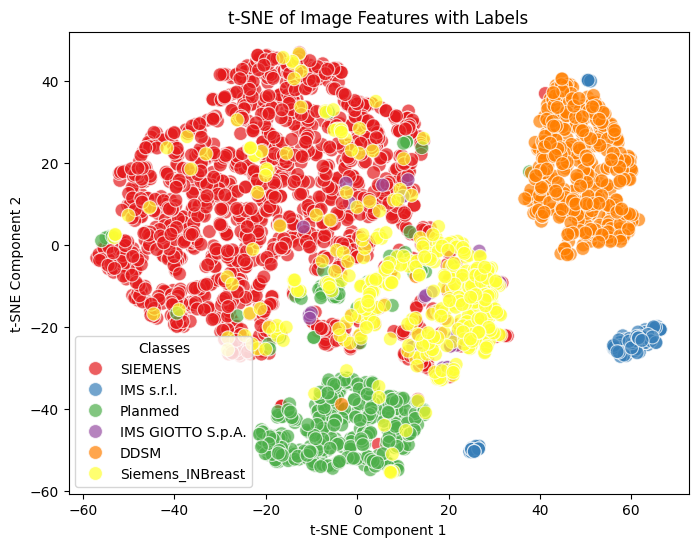

In [6]:
if(stage=='process'):
    min_features = ['mean', 'std', 'kurtosis', 'area_under_histogram', 'homogeneity_1', 'correlation_2', 'contrast_2', 'dissimilarity_3', 'ASM_2']
    feature_set = image_stats_df[min_features]   
    features = np.array(feature_set)
    labels = image_stats_df['vendor'].values
    results = run_tsne(features, labels)

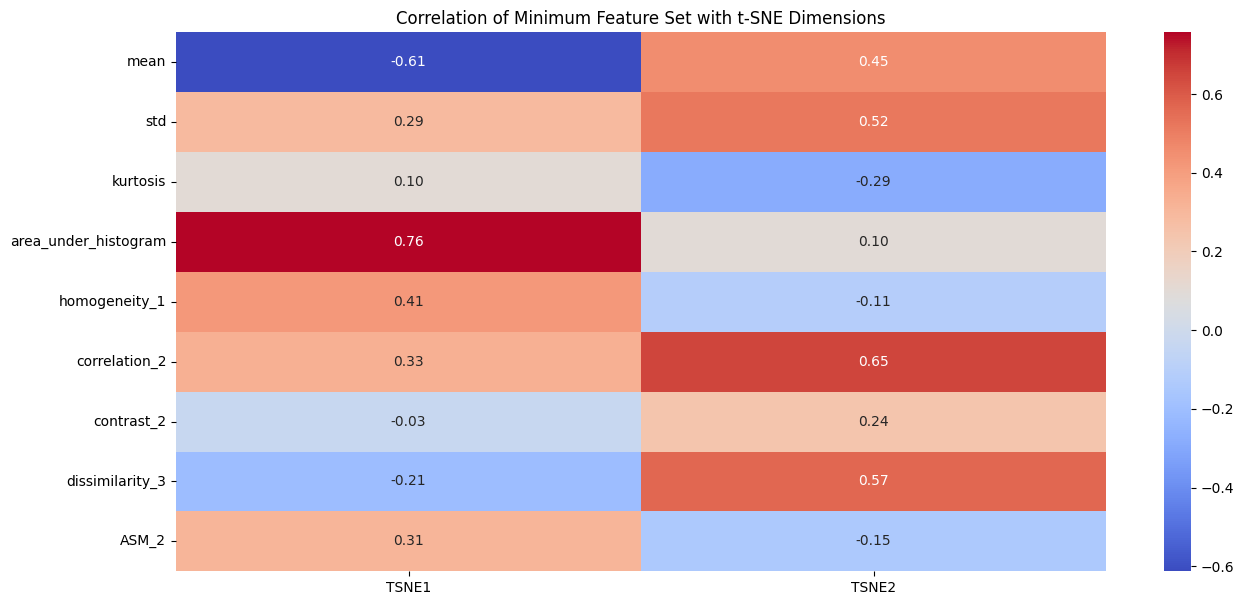

In [7]:
if(stage=='process'):
    correlations = pd.concat([feature_set, results.iloc[:,:2]], axis=1).corr()
    tsne_corr = correlations.loc[feature_set.columns, results.iloc[:,:2].columns]
    plt.figure(figsize=(15, 7))
    sns.heatmap(tsne_corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation of Minimum Feature Set with t-SNE Dimensions")
    plt.show()

In [8]:
image_stats_df['vendor'] = image_stats_df['vendor'].replace(['IMS s.r.l.', 'IMS GIOTTO S.p.A.'], 'IMS')
df = image_stats_df.groupby('vendor').sample(n=70)
input_size, num_classes, train_loader, test_loader, le = get_datasets(df)
model, criterion, optimizer = build_model(input_size, num_classes)
train_metrics = train_model(model, optimizer, criterion, train_loader)

 18%|█▊        | 36/200 [00:01<00:04, 33.42it/s]

Early stopping at epoch 37


In [9]:
if(stage=='process'):
    image_stats_df['vendor'] = image_stats_df['vendor'].replace(['IMS s.r.l.', 'IMS GIOTTO S.p.A.'], 'IMS')
    
    acc = []
    f1 = []
    for i in range(100):
        df = image_stats_df.groupby('vendor').sample(n=70)
        _, _, _, test_loader, le = get_datasets(df)
        # model = torch.load('model.pth')
        model = model.eval()
        test_metrics = test_model(model, test_loader)
        acc.append(test_metrics['accuracy'][0])
        f1.append(test_metrics['f1'][0])
    
    test_accuracy = np.mean(acc)
    test_f1 = np.mean(f1)
    
    print(f"Test Metrics - Accuracy: {test_accuracy:.4f}, F1: {test_f1:.4f}") 


Test Metrics - Accuracy: 0.9124, F1: 0.9140


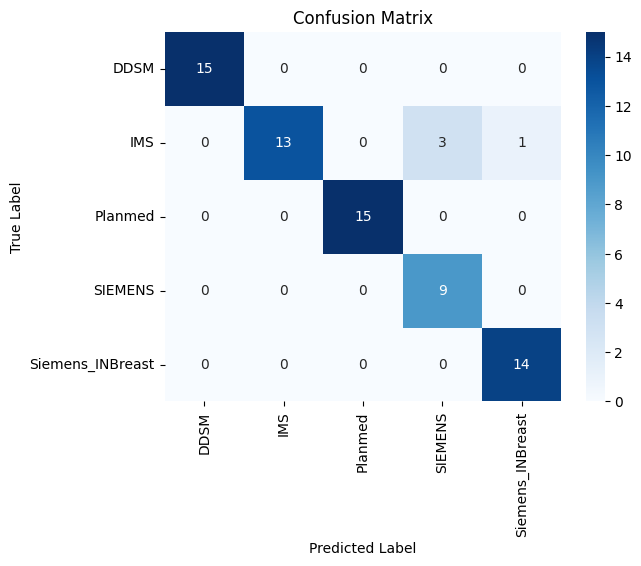

                  precision    recall  f1-score   support

            DDSM       1.00      1.00      1.00        15
             IMS       1.00      0.76      0.87        17
         Planmed       1.00      1.00      1.00        15
         SIEMENS       0.75      1.00      0.86         9
Siemens_INBreast       0.93      1.00      0.97        14

        accuracy                           0.94        70
       macro avg       0.94      0.95      0.94        70
    weighted avg       0.95      0.94      0.94        70



In [10]:
if(stage=='process'):
    plot_cm(model, test_loader, le)

In [198]:
if(stage == 'process'):
    with open('Classification Results/normalized_mild_processing_windows.json', 'w') as json_file:
        json.dump({'accuracy': test_accuracy, 'f1': test_f1}, json_file, indent=4)

In [12]:
image_stats_df = pd.read_csv('complete_stats_normalized.csv')
image_stats_df['vendor'] = image_stats_df['vendor'].replace(['IMS s.r.l.', 'IMS GIOTTO S.p.A.'], 'IMS')
image_stats_df.groupby('vendor')[min_features].agg('mean')

,mean,std,kurtosis,area_under_histogram,homogeneity_1,correlation_2,contrast_2,dissimilarity_3,ASM_2
vendor,,,,,,,,,
DDSM,0.432681,0.206343,0.176878,7.410778e+06,0.126046,0.624698,1567.595506,38.005893,0.000214
IMS,0.278535,0.260282,6.916348,5.623442e+06,0.724421,0.771108,1320.085411,17.109645,0.331057
Planmed,0.819905,0.257918,-0.423830,3.743751e+06,0.702405,0.894698,882.120103,19.632972,0.434710
SIEMENS,0.610528,0.110724,2.456804,1.732206e+06,0.109072,0.485051,679.553414,24.902711,0.000244
Siemens_INBreast,0.510761,0.085548,2.890051,3.492595e+06,0.132029,0.540957,384.406684,18.060448,0.000518


In [20]:
import cv2
from helpers import apply_clahe

In [27]:
image_stats_df.iloc[1940]['vendor']

'IMS'

In [31]:
means = []
for i in tqdm(range(1950, 1960)):
    img = pydicom.dcmread(image_stats_df['file_name'].iloc[i]).pixel_array
    _, thresholded = cv2.threshold(img, 0, 65535, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    img = cv2.bitwise_and(img, img, mask=thresholded.astype(np.uint8))
    img = np.where(thresholded == 0, 0, img)
    means.append(np.mean(img[img>0]))
np.mean(means)

100%|██████████| 10/10 [00:00<00:00, 16.87it/s]


np.float64(8861.728733190306)

np.float64(5026.215693084068)

In [11]:
image_stats_df.groupby('vendor')[min_features].agg('mean')

,mean,std,kurtosis,area_under_histogram,homogeneity_1,correlation_2,contrast_2,dissimilarity_3,ASM_2
vendor,,,,,,,,,
DDSM,0.415413,0.208284,-0.288991,7.474931e+06,0.105813,0.587358,1908.100078,44.456017,0.000084
IMS,0.346170,0.223325,6.940091,4.841029e+06,0.577551,0.699574,1169.862183,19.195772,0.255284
Planmed,0.360768,0.142649,0.389432,1.807297e+06,0.072322,0.404162,1365.512301,33.126833,0.000115
SIEMENS,0.549957,0.163823,-0.010604,1.728596e+06,0.076206,0.552866,1337.257158,37.533295,0.000091
Siemens_INBreast,0.456162,0.135610,0.478855,3.489480e+06,0.077766,0.543874,992.767117,30.451536,0.000128


In [12]:
image_stats_df.groupby('vendor')[min_features].agg('mean')

,mean,std,kurtosis,area_under_histogram,homogeneity_1,correlation_2,contrast_2,dissimilarity_3,ASM_2
vendor,,,,,,,,,
DDSM,0.210791,0.248424,-0.359970,1.180848e+07,0.528071,0.843236,1096.284244,28.141076,0.217898
IMS,0.285799,0.279918,6.879323,5.490609e+06,0.657151,0.589361,6776.657882,38.187361,0.279990
Planmed,0.774486,0.247465,-0.436513,4.729998e+06,0.708089,0.895902,799.508918,18.637897,0.433532
SIEMENS,0.910108,0.276091,7.796406,4.926784e+06,0.901586,0.389902,6058.242688,26.275043,0.663008
Siemens_INBreast,0.681412,0.444839,-1.133081,5.295746e+06,0.868172,0.878525,3107.473283,26.315194,0.426651


In [16]:
image_stats_df.groupby('vendor')[min_features].agg('mean')

,mean,std,kurtosis,area_under_histogram,homogeneity_1,correlation_2,contrast_2,dissimilarity_3,ASM_2
vendor,,,,,,,,,
DDSM,0.233949,0.243143,-0.377021,1.140000e+07,0.530548,0.843039,1080.318387,27.714466,0.227152
IMS,0.284928,0.280538,6.881454,5.488400e+06,0.661862,0.596302,6483.901864,37.124360,0.283561
Planmed,0.247114,0.315942,2.579690,4.907369e+06,0.787621,0.266073,9897.806706,46.113765,0.440353
SIEMENS,0.825120,0.357558,1.748150,4.925961e+06,0.923754,0.854720,2292.642881,19.021836,0.583181
Siemens_INBreast,0.475577,0.091096,2.101065,3.492681e+06,0.106816,0.436356,590.968991,21.467782,0.000284


pixel intensity: DDSM, PLANMED, IMS, SIB, SIEMENS
Variance: SIB, DDSM, IMS, PLANMED, SIEMENS
Homogeneity: SIB, DDSM, IMS, PLANMED, SIEMENS
Correlation: PLANMED, SIB, IMS, DDSM, SIEMENS
Contrast: SIB, DDSM, SIEMENS, IMS, PLANMED
Dissimilarity: SIEMENS, SIB, DDSM, IMS, PLANMED
ASM: SIB, DDSM, IMS, PLANMED, SIEMENS

Siemens: Reduce Pixel Intensity, Variance, Homogeneity, Correlation, ASM
         Increase Contrast, Dissimilarity

SIB: Reduce Pixel Intensity
     Increase Variance, Homogeneity,, ASM, Contrast

Planmed: Reduce Contrast, Dissimilarity

DDSM: Increase Homogeneity, ASM, Pixel Intensity

In [ ]:
SIEMENS = 0.9217
Planmed = 0.9433
IMS = 0.8837
DDSM = 0.67
Sample = 0.806

In [127]:
34796/1453

23.947694425326908

In [31]:
from helpers import apply_clahe, wavelet_denoising, gamma_correction

In [35]:
def gamma_correction(image, gamma= 1.0):
    normalized = image / 65535.0
    corrected = np.power(normalized, gamma)
    corrected = np.clip(corrected * 65535, 0, 65535).astype(np.uint16)
    return corrected

In [90]:
img = pydicom.dcmread(image_stats_df.iloc[2100]['file_name']).pixel_array
# img[20]
# plt.imshow(img, cmap='gray')
img = mask_image(img)
pro_img = process_image(img, image_stats_df.iloc[2000]['vendor'])
pro_img = np.uint16(pro_img)
pro_img = apply_clahe(pro_img)
# pro_img = np.uint16(pro_img)
# zero_mask = pro_img == 0
# pro_img = apply_clahe(pro_img)
# pro_img[zero_mask] = 0
# # pro_img = apply_clahe(np.uint16(pro_img))
# pro_img = gamma_correction(pro_img, 0.8)
# # pro_img
pro_img
# plt.imshow(pro_img, cmap='gray')


array([[ 9453,  9566,  9519, ..., 16511, 16511, 16511],
       [ 9506,  9572,  9471, ..., 16511, 16511, 16511],
       [ 9492,  9496,  9377, ..., 16511, 16511, 16511],
       ...,
       [ 8550,  8541,  8545, ..., 14025, 14025, 14025],
       [ 8675,  8668,  8636, ..., 14025, 14025, 14025],
       [ 8572,  8697,  8689, ..., 14025, 14025, 14025]], dtype=uint16)

In [77]:
dcmdata = pydicom.dcmread(image_stats_df.iloc[2100]['file_name'])
dcmdata

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 194
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9590.100.1.2.335138229713428248738857634623646058723
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.35'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9590.100.1.2.335138229713428248738857634623646058723
(0008, 0020) Study Date                          DA: ''
(0008, 0023) Content Date     

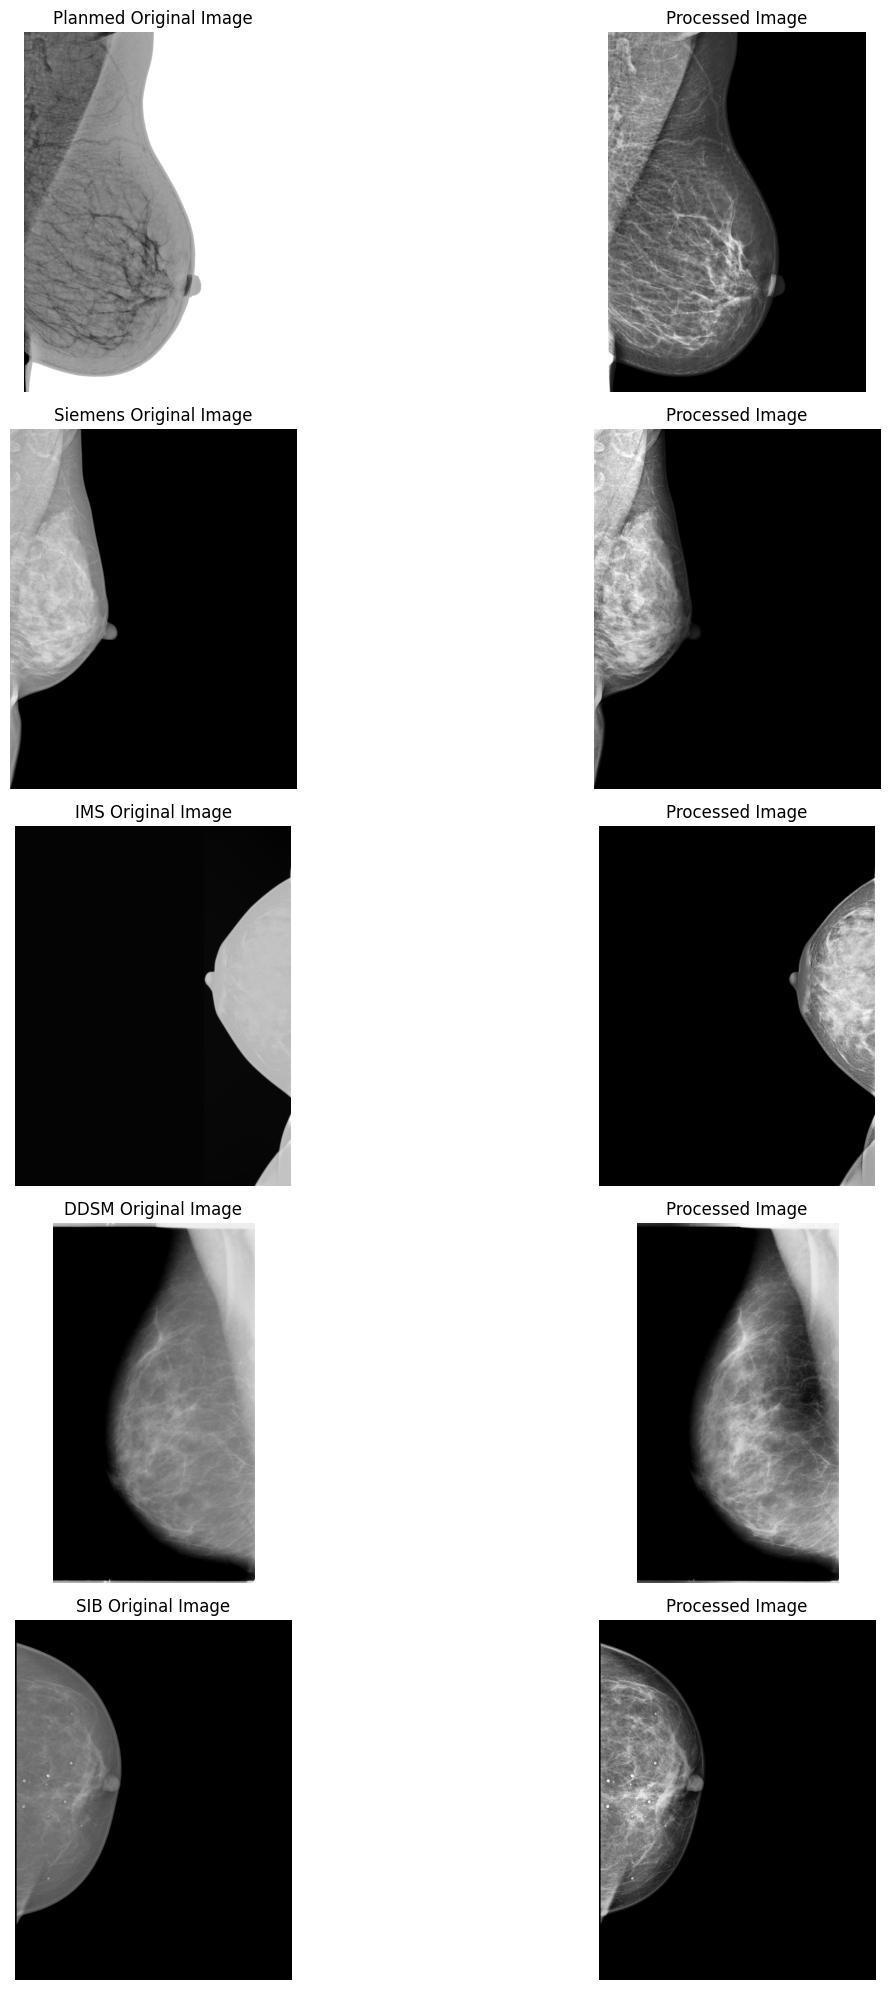

In [32]:
img = pydicom.dcmread(image_stats_df.iloc[1600]['file_name']).pixel_array
img = mask_image(img)
pro_img = process_image(img, image_stats_df.iloc[1600]['vendor'])
pro_img = np.uint16(pro_img)
pro_img = apply_clahe(pro_img)
fig, axes = plt.subplots(5, 2, figsize=(15, 20))  # 1 row, 2 columns
axes[0][0].imshow(img, cmap='gray')
axes[0][0].set_title('Planmed Original Image')
axes[0][0].axis('off')
axes[0][1].imshow(pro_img, cmap='gray')
axes[0][1].set_title('Processed Image')
axes[0][1].axis('off')


img = pydicom.dcmread(image_stats_df.iloc[100]['file_name']).pixel_array
img = mask_image(img)
pro_img = process_image(img, image_stats_df.iloc[100]['vendor'])
pro_img = np.uint16(pro_img)
pro_img = apply_clahe(pro_img)
axes[1][0].imshow(img, cmap='gray')
axes[1][0].set_title('Siemens Original Image')
axes[1][0].axis('off')
axes[1][1].imshow(pro_img, cmap='gray')
axes[1][1].set_title('Processed Image')
axes[1][1].axis('off')

img = pydicom.dcmread(image_stats_df.iloc[2000]['file_name']).pixel_array
img = mask_image(img)
pro_img = process_image(img, image_stats_df.iloc[2000]['vendor'])
pro_img = np.uint16(pro_img)
pro_img = apply_clahe(pro_img)
axes[2][0].imshow(img, cmap='gray')
axes[2][0].set_title('IMS Original Image')
axes[2][0].axis('off')
axes[2][1].imshow(pro_img, cmap='gray')
axes[2][1].set_title('Processed Image')
axes[2][1].axis('off')

img = pydicom.dcmread(image_stats_df.iloc[2100]['file_name']).pixel_array
img = mask_image(img)
pro_img = process_image(img, image_stats_df.iloc[2100]['vendor'])
pro_img = np.uint16(pro_img)
pro_img = apply_clahe(pro_img)
axes[3][0].imshow(img, cmap='gray')
axes[3][0].set_title('DDSM Original Image')
axes[3][0].axis('off')
axes[3][1].imshow(pro_img, cmap='gray')
axes[3][1].set_title('Processed Image')
axes[3][1].axis('off')

img = pydicom.dcmread(image_stats_df.iloc[2600]['file_name']).pixel_array
img = mask_image(img)
pro_img = process_image(img, image_stats_df.iloc[2600]['vendor'])
pro_img = np.uint16(pro_img)
pro_img = apply_clahe(pro_img)
axes[4][0].imshow(img, cmap='gray')
axes[4][0].set_title('SIB Original Image')
axes[4][0].axis('off')
axes[4][1].imshow(pro_img, cmap='gray')
axes[4][1].set_title('Processed Image')
axes[4][1].axis('off')

plt.tight_layout()
plt.show()

